![Alt Text](./GenAI.png)

In [1]:
## Cheinformatics 
## Deep Generative Molecular Design Applied to Anthracyclin drug class.
## 5/30/2023 at 16:00 EST
## First Step: Building and testing of: 
    #(1)Conversion of molecules to fingerprints
    #(2)Working Variational Autoencoder Model (VAE) [Further improvement needs to be done to optimize the model hyperparameters]
    #(3)Reconvert the decoder output back to SMILES string and valid molecules.

##Constraints: 
    #(1)Limited computing resources
    #(2)Limited dataset 
    #(3)Inability to properly represent some of the complex molecules with 'selfies' string 

In [458]:
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [459]:
## smiles string of the chemical molecules 
## these molecules belongs to the anthracycline class for breast cancer chemotheraphy. 

input_smiles_list = ['CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)C)O)N)O',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=CC=CC=C5C4=O)O)(C(=O)C)O)N)O',\
                     'C1=CC(=C2C(=C1NCCNCCO)C(=O)C3=C(C=CC(=C3C2=O)O)O)NCCNCCO',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)OC6CCCCO6',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=NNC(=O)C6=CC=CC=C6)C)O)N)O',\
                     'CC(=O)C1(CC(C2=C(C1)C(=C3C(=C2O)C(=O)C4=CC=CC=C4C3=O)O)OC5CC(C(CO5)O)O)N',\
                     'C1=CC(=C2C(=C1NCCN)C(=O)C3=C(C2=O)C=NC=C3)NCCN',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N6CCOC(C6)OC)O',\
                     'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)O)O)(C(=O)C)O)N)O',\
                     'C1=CC=C2C(=C1)C(=O)C3=C(C=CC(=C3C2=O)NCCNCCO)NCCNCCO',\
                     'CC1=C(C2=C(C=C1)C(=O)N3C=C(CC3C(N2)O)C=CC(=O)N)O',\
                    ]

input_selfies_list = list(map(sf.encoder, input_smiles_list))
input_selfies_list

['[C][C][C][Branch2][=Branch1][Branch1][C][Branch2][Branch1][S][C][C][Branch1][Ring2][O][Ring1][=Branch1][O][C][C][C][Branch2][Ring2][=Branch2][C][C][=C][Ring1][=Branch1][C][=Branch2][Ring1][#C][=C][C][=Branch1][Branch1][=C][Ring1][=Branch1][O][C][=Branch1][C][=O][C][=C][Branch1][Branch1][C][Ring1][=Branch2][=O][C][=Branch1][=Branch1][=C][C][=C][Ring1][Branch2][O][C][O][Branch1][#Branch1][C][=Branch1][C][=O][C][O][O][N][O]',
 '[C][C][C][Branch2][=Branch1][Branch1][C][Branch2][Branch1][S][C][C][Branch1][Ring2][O][Ring1][=Branch1][O][C][C][C][Branch2][Ring2][=Branch2][C][C][=C][Ring1][=Branch1][C][=Branch2][Ring1][#C][=C][C][=Branch1][Branch1][=C][Ring1][=Branch1][O][C][=Branch1][C][=O][C][=C][Branch1][Branch1][C][Ring1][=Branch2][=O][C][=Branch1][=Branch1][=C][C][=C][Ring1][Branch2][O][C][O][Branch1][#Branch1][C][=Branch1][C][=O][C][O][O][N][O]',
 '[C][C][C][Branch2][=Branch1][Ring2][C][Branch2][Branch1][#C][C][C][Branch1][Ring2][O][Ring1][=Branch1][O][C][C][C][Branch2][Ring2][=Branch2]

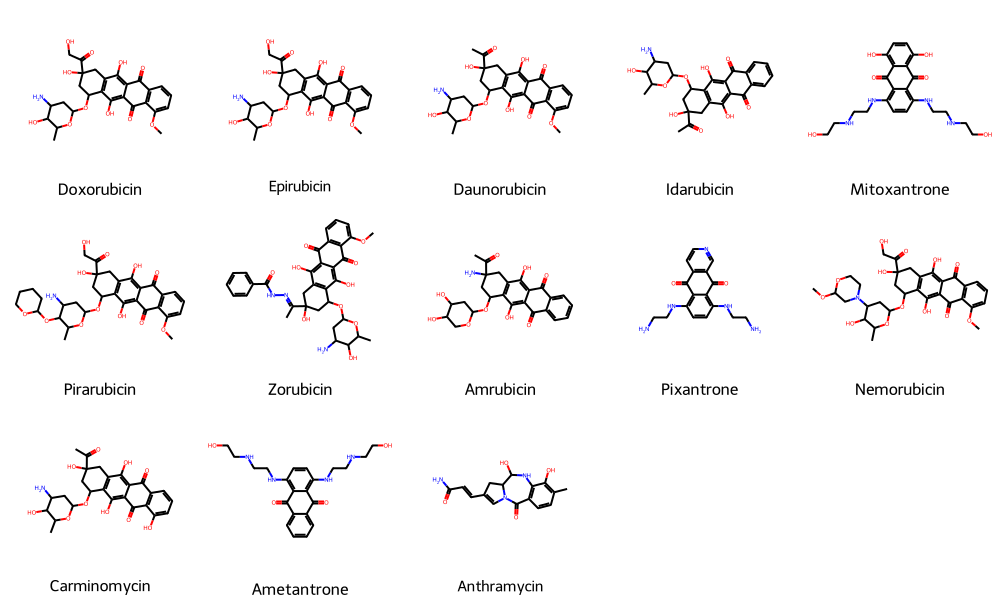

In [460]:
## Visualizing the molecules using RDkit

molecule_names =  ['Doxorubicin','Epirubicin','Daunorubicin','Idarubicin','Mitoxantrone', 'Pirarubicin', 'Zorubicin',\
                  'Amrubicin', 'Pixantrone', 'Nemorubicin', 'Carminomycin', 'Ametantrone', 'Anthramycin']
input_mol_list = []
for smiles in input_smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    input_mol_list.append(mol)
img = Draw.MolsToGridImage(input_mol_list, molsPerRow=5, legends = [str(x) for x in molecule_names])
img

In [461]:
## Find out the maximum length in the list

max_len = max(sf.len_selfies(s) for s in input_selfies_list)
max_len

88

In [462]:
## Identify the unique SELFIES symbols (alphabets)
alphabet = sf.get_alphabet_from_selfies(input_selfies_list)

## add [nop] to the symbols (alphabet)
alphabet.add("[nop]")

## convert the tuple to list and sort
alphabet= list(sorted(alphabet))
alphabet

['[#Branch1]',
 '[#C]',
 '[=Branch1]',
 '[=Branch2]',
 '[=C]',
 '[=N]',
 '[=O]',
 '[Branch1]',
 '[Branch2]',
 '[C]',
 '[N]',
 '[O]',
 '[Ring1]',
 '[Ring2]',
 '[S]',
 '[nop]']

In [463]:
### Map the SELFIES symbols to indices

vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_stoi

{'[#Branch1]': 0,
 '[#C]': 1,
 '[=Branch1]': 2,
 '[=Branch2]': 3,
 '[=C]': 4,
 '[=N]': 5,
 '[=O]': 6,
 '[Branch1]': 7,
 '[Branch2]': 8,
 '[C]': 9,
 '[N]': 10,
 '[O]': 11,
 '[Ring1]': 12,
 '[Ring2]': 13,
 '[S]': 14,
 '[nop]': 15}

In [464]:
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}
vocab_itos

{0: '[#Branch1]',
 1: '[#C]',
 2: '[=Branch1]',
 3: '[=Branch2]',
 4: '[=C]',
 5: '[=N]',
 6: '[=O]',
 7: '[Branch1]',
 8: '[Branch2]',
 9: '[C]',
 10: '[N]',
 11: '[O]',
 12: '[Ring1]',
 13: '[Ring2]',
 14: '[S]',
 15: '[nop]'}

In [465]:
label, one_hot = sf.selfies_to_encoding(input_selfies_list[0], vocab_stoi, pad_to_len=max_len)
input_one_hot_arr = np.expand_dims(np.array(one_hot), axis=0)


for i in range (1,len(input_selfies_list)):
    label, one_hot = sf.selfies_to_encoding(input_selfies_list[i], vocab_stoi, pad_to_len=max_len)
    one_hot_arr = np.expand_dims(np.array(one_hot), axis=0)
    input_one_hot_arr = np.vstack((input_one_hot_arr,one_hot_arr))
    
input_one_hot_arr

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [466]:
## The input_one_hot_arr is the encoded dataset to be trained
## It contains 20 molecules, each represented in a 2D array of size 20 x 15. 

train_dataset = input_one_hot_arr


train_dataset.shape

(13, 88, 16)

In [467]:
train_dataset[0].shape

(88, 16)

In [468]:
train_dataset[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [469]:
### Building the Deep Generative Model 
## Using Variational Autoencoder

# Reshape X_train to 2D array
input_dim = train_dataset.shape[1] * train_dataset.shape[2]
X_train = train_dataset.reshape(-1, input_dim)

# Define the dimensions of the latent space
latent_dim = 2  # You can adjust this according to your needs

In [470]:
# Define the encoder model
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [471]:
# Define the sampling layer to sample from the distribution defined by z_mean and z_log_var
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [472]:
# Define the decoder model

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(decoder_inputs)
x = layers.Dense(128, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim, activation="sigmoid")(x)

input_dim

1408

In [473]:
# Define the VAE model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

In [474]:
# Define the VAE loss function
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [475]:
# Compile the VAE model
vae.compile(optimizer="adam")

In [476]:
# Train the VAE model
vae.fit(X_train, epochs=500, batch_size=256, verbose=0)

In [477]:
# Generate decoded data
X_decoded = vae.predict(X_train)
len(X_decoded)
X_train.shape

1/1 [==============================] - 0s 88ms/step


(13, 1408)

In [478]:
# Reshape X_decoded back to 3D array
X_decoded = X_decoded.reshape(train_dataset.shape)

In [479]:
max_values = np.max(X_decoded, axis=2, keepdims=True)
decoded_data = np.where(X_decoded == max_values, 1, 0)

decoded_data[4]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [480]:
### Process the decoder output into smiles and chemical structures 
## Reproduce SMILES list and visualize the output images 

output_smiles_list = []
for i in range (0,len(decoded_data)):
    sm = sf.decoder(sf.encoding_to_selfies(decoded_data[i].tolist(), vocab_itos, enc_type="one_hot"))
    output_smiles_list.append(sm)
    
output_smiles_list


['CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O',
 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O',
 'CC1CC(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N',
 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=CC=CC=C5C4=O)O)(C(=O)C)O)N)O',
 'C1=CC(=C2C(=C1NCCNCCO)C(=O)C3=C(C=CC(=C3C2=O)O)O)NCCNCCO',
 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O6)N)OCOC6O',
 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=NNC(=O)C6=CC=CC=C6)C)O)N)O',
 'CCCC=O',
 'C1=CC=CC(=C1NCCN)C(=O)C2=C(COC=NC=C2NCCN)O',
 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N6CCOC(C6)OC)O',
 'CC1CC(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C)C=O)O',
 'C1=CC=C2C(=C1)C(=O)C3=C(C=CC(=C3C2=O)NCCNCCO)NCCNCCO',
 'CC1=C(C2=C(C=C1)C(=O)N3C=C(CC3C(N2)O)C=CC(=O)N)O']

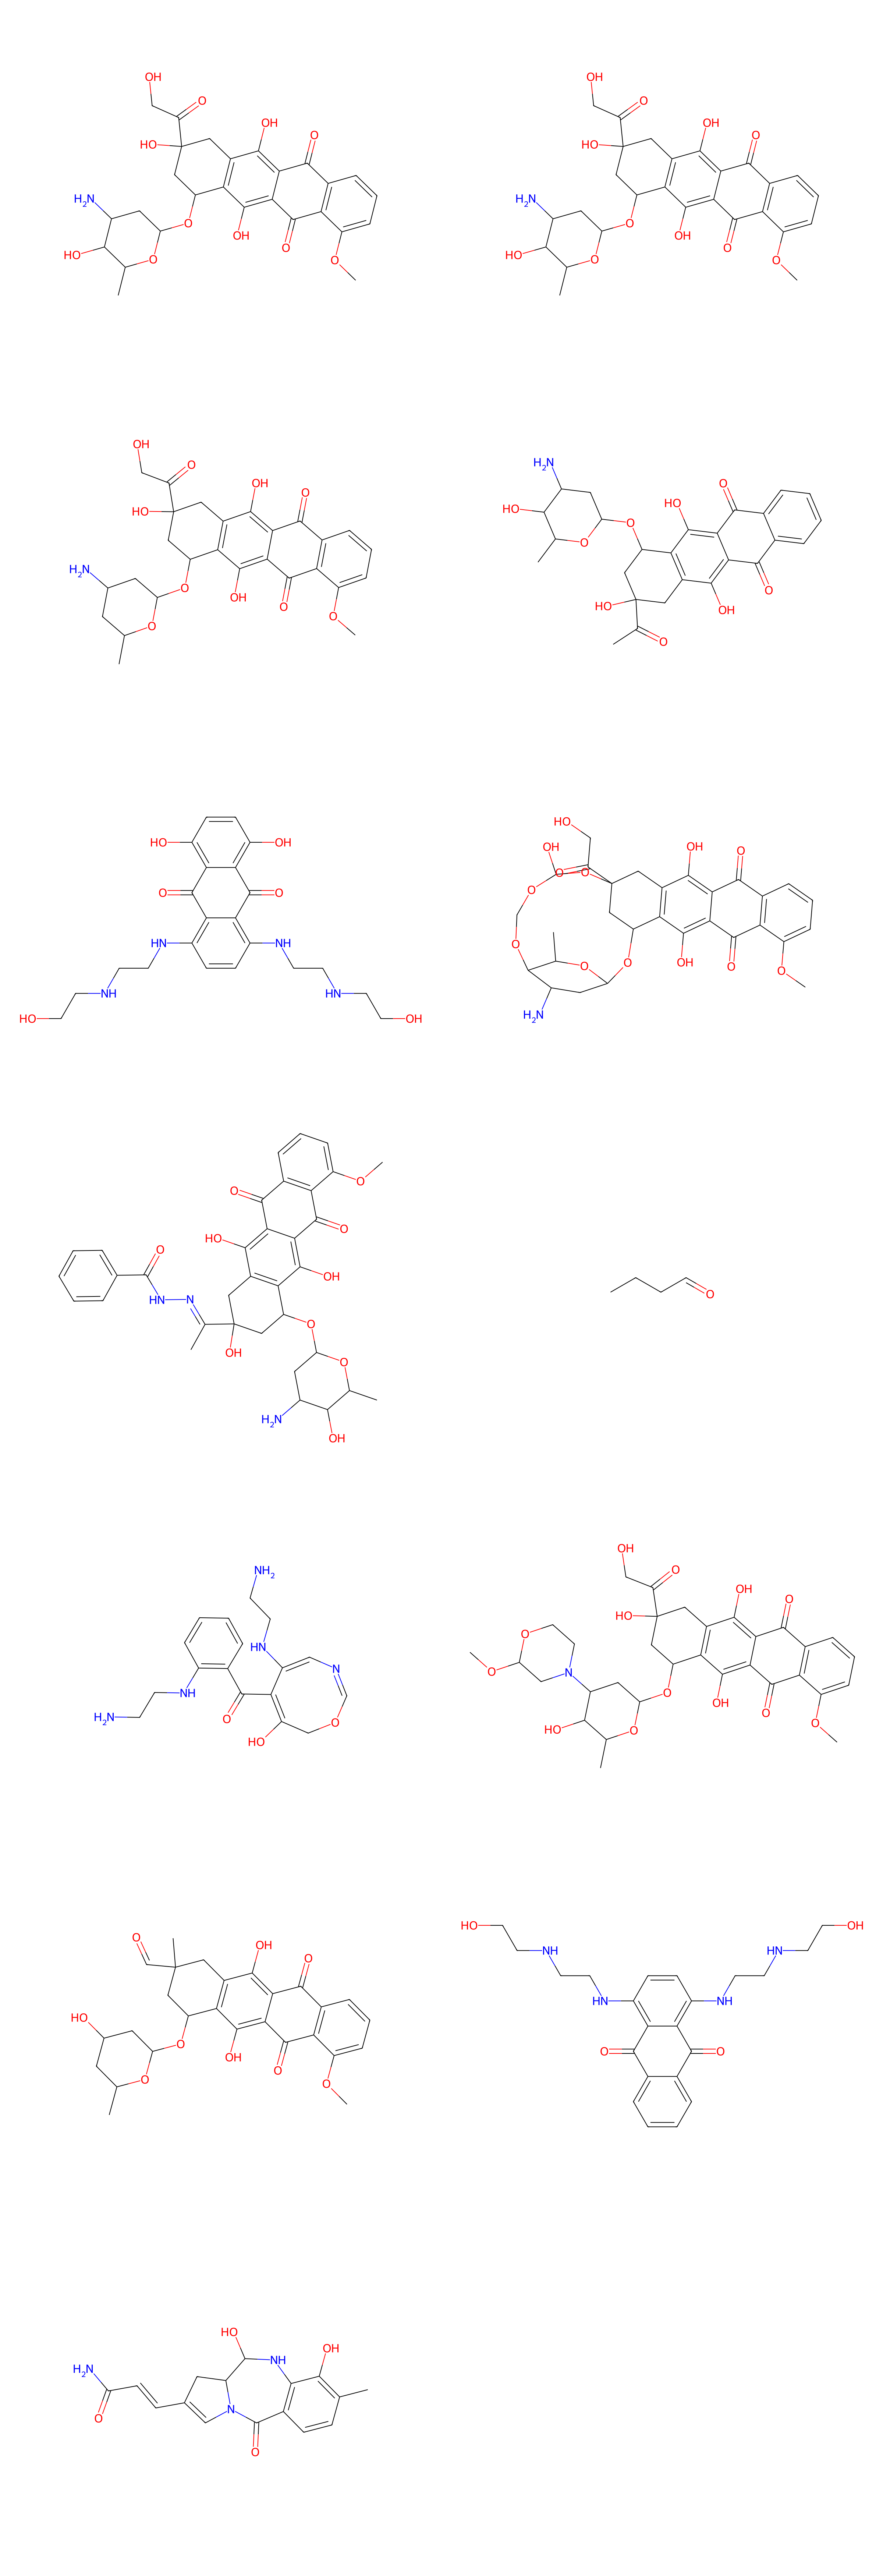

In [481]:
output_mol_list = []
for smiles in output_smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    output_mol_list.append(mol)
img = Draw.MolsToGridImage(output_mol_list, molsPerRow=2, subImgSize=(1200, 1000))
img